## Reconciliation Analytics for E-commerce Transactions
* Background:
  * You're working for an e-commerce company that utilizes multiple payment gateways and
  internal systems to record transactions. Occasionally, discrepancies arise between what's
  recorded in the internal system versus what the payment gateways report. Reconciliation is
  crucial to ensure financial accuracy.
* Objective:
  * Your task is to analyze the discrepancies, create a model to predict when and where
  discrepancies might occur in the future, and develop a streamlined data pipeline to facilitate
  regular reconciliation efforts.

### Import the necessary Dependencies


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



import warnings
warnings.filterwarnings('ignore')


### Setup Config

In [ ]:
class CFG:
  path = "/content/"

### Build The Dataset
* We are trying to reconcile  the payment records from the payment gateways to the records in the internal system
* But first let us understand the problem. What really is a discrepancy??. In the given document:

  * Transaction T0001 has a slight discrepancy in the Amount.(clear)
  * Transaction T0003 also has a slight discrepancy in the Amount.(clear)
  * Transaction T0006 in gateway_transactions.csv has a discrepancy, while the one in
  internal_transactions.csv has a different amount for the same product and date.
    * while the one in internal transactions has a different amount for the same product and date? Meaning even the internal transactions can have conflicts within itself??

    * Here I am going to assume that because there is no stakeholder to ask this question
  * gateway_transactions.csv contains an extra transaction T0007.(clear)

  * What about T0005, is it not a discrepancy because it is missing in the gateway_transactions.csv??
    * This is one of the questions where I would have asked the stakeholder for more clarity because of the ambiguity nature. But since they are not here I am gonna assume its not and fill it with dummy values

  * So final assumption:
    * T001, T003, T006 and T007 are the ones with discrepancies

In [ ]:
# We were not given any csv files but the instructions told use to extract the files from the given documents and this is what I came up with from the document

def build_datasets(internal_data: str, gateway_data: str)-> None:
  """
  Write data to csv files
  """
  with open('internal_transactions.csv', 'w') as f:
      f.write(internal_data)

  with open('gateway_transactions.csv', 'w') as f:
      f.write(gateway_data)




In [ ]:
internal_data = """Transaction_ID,Date,Product_ID,Amount
T0001,2021-01-01,A1001,299.99
T0002,2021-01-01,A1002,159.50
T0003,2021-01-02,A1001,299.99
T0004,2021-01-02,A1003,49.99
T0005,2021-01-03,A1004,89.90
T0006,2021-01-03,A1002,159.40"""

gateway_data = """Transaction_ID,Date,Product_ID,Amount
T0001,2021-01-01,A1001,299.89
T0002,2021-01-01,A1002,159.50
T0003,2021-01-02,A1001,300.00
T0004,2021-01-02,A1003,49.99
T0005,2021-01-03,A1004,89.90
T0007,2021-01-04,A1004,89.90"""

build_datasets(internal_data, gateway_data)

### Analytics
  * Conduct an exploratory data analysis (EDA) to understand the discrepancies between the two
  systems.
  * Identify patterns: Are discrepancies more common with certain products? On particular days or
  times? With specific amounts?
  * Calculate the total financial impact of these discrepancies over time.

In [ ]:

gateway = pd.read_csv(CFG.path + "gateway_transactions.csv").sort_values(by=['Transaction_ID'])
internal = pd.read_csv(CFG.path + "internal_transactions.csv").sort_values(by=['Transaction_ID'])

display("The gateway transactions",
        gateway,
        "The internal transactions",
        internal)

'The gateway transactions'

,Transaction_ID,Date,Product_ID,Amount
0,T0001,2021-01-01,A1001,299.89
1,T0002,2021-01-01,A1002,159.50
2,T0003,2021-01-02,A1001,300.00
3,T0004,2021-01-02,A1003,49.99
4,T0005,2021-01-03,A1004,89.90
5,T0007,2021-01-04,A1004,89.90


'The internal transactions'

,Transaction_ID,Date,Product_ID,Amount
0,T0001,2021-01-01,A1001,299.99
1,T0002,2021-01-01,A1002,159.50
2,T0003,2021-01-02,A1001,299.99
3,T0004,2021-01-02,A1003,49.99
4,T0005,2021-01-03,A1004,89.90
5,T0006,2021-01-03,A1002,159.40


**Unique Ids present in gateway transactions not in internal transactions:** {'T0007'}

,Transaction_ID,Date_internal,Product_ID_internal,Amount_internal,Date_gateway,Product_ID_gateway,Amount_gateway,Occurrence_Position
0,T0001,2021-01-01,A1001,299.99,2021-01-01,A1001,299.89,1
2,T0003,2021-01-02,A1001,299.99,2021-01-02,A1001,300.00,1
5,T0006,2021-01-03,A1002,159.40,0,0,0.00,2
6,T0007,0,0,0.00,2021-01-04,A1004,89.90,1


**Summary Statistics:**

,Amount_gateway,Amount_internal
count,7.000000,7.000000
mean,141.311429,151.252857
std,118.500945,116.387022
min,0.000000,0.000000
25%,69.945000,69.945000
50%,89.900000,159.400000
75%,229.695000,229.745000
max,300.000000,299.990000


**Total Financial Impact of Discrepancies:** 69.59

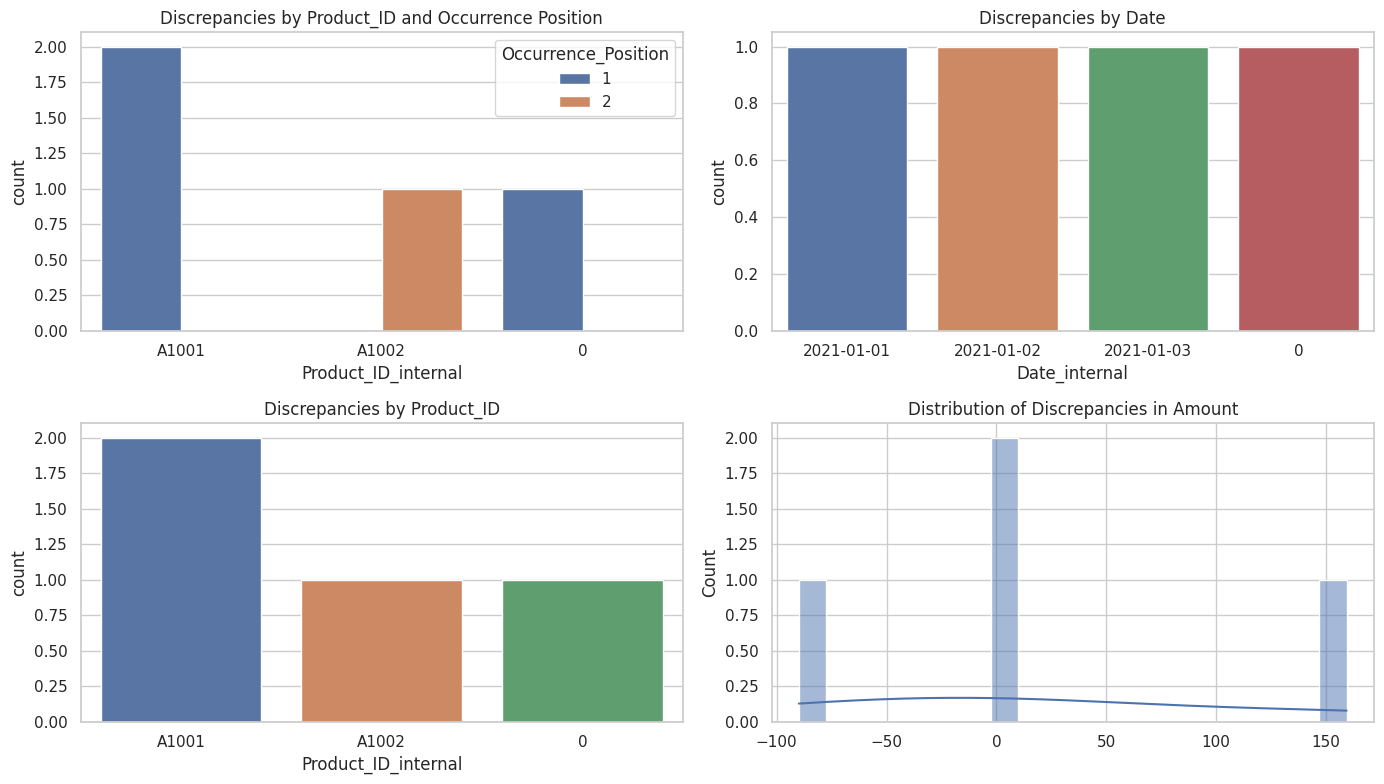

In [ ]:
def perform_eda(internal_transactions, gateway_transactions):

    # Find the transaction ID's present in gateway and not in internal
    discrepancy_ids = set(gateway_transactions.Transaction_ID.unique()) - set(internal_transactions.Transaction_ID.unique())
    display(Markdown(f"**Unique Ids present in gateway transactions not in internal transactions:** {discrepancy_ids}"))

    # Merge the two DataFrames on 'Transaction_ID'
    merged_transactions = pd.merge(internal_transactions, gateway_transactions, on='Transaction_ID', suffixes=('_internal', '_gateway'), how = 'outer')

    #fill missing transactions with zeros
    merged_transactions.fillna(0, inplace= True)

    # Identify discrepancies based on Amount
    discrepancies = merged_transactions[merged_transactions['Amount_internal'] != merged_transactions['Amount_gateway']]

    # Add occurrence position by Product_ID to discrepancies
    discrepancies['Occurrence_Position'] = np.where(discrepancies.index % 2 == 0, 1, 2)

    display(discrepancies)


    # Display general information about the data

    display(Markdown("**Summary Statistics:**"))
    display(merged_transactions[['Amount_gateway', 'Amount_internal']].describe())

    # Check if there are discrepancies before visualizing
    if not discrepancies.empty:
        # Visualize discrepancies
        sns.set(style="whitegrid")
        plt.figure(figsize=(14, 8))

        # Discrepancies by Product_ID
        plt.subplot(2, 2, 3)
        sns.countplot(x='Product_ID_internal', data=discrepancies)
        plt.title('Discrepancies by Product_ID')


        # Discrepancies by Product_ID and Occurrence Position
        plt.subplot(2, 2, 1)
        sns.countplot(x='Product_ID_internal', hue='Occurrence_Position', data=discrepancies)
        plt.title('Discrepancies by Product_ID and Occurrence Position')

        # Discrepancies by Date
        plt.subplot(2, 2, 2)
        sns.countplot(x='Date_internal', data=discrepancies)
        plt.title('Discrepancies by Date')


        # Discrepancies by Amount
        plt.subplot(2, 2, 4)
        sns.histplot(discrepancies['Amount_internal'] - discrepancies['Amount_gateway'], bins=20, kde=True)
        plt.title('Distribution of Discrepancies in Amount')

        # Calculate the total financial impact of discrepancies
        total_impact = discrepancies['Amount_internal'].sum() - discrepancies['Amount_gateway'].sum()
        display(Markdown(f"**Total Financial Impact of Discrepancies:** {total_impact:.2f}"))

        plt.tight_layout()
        plt.show()
    else:
        display(Markdown("**No discrepancies found in the data.**"))\



perform_eda(internal, gateway)


### Concusions from the Above Study:
* We only have one transaction present in gateway transactions that is not in internal transactions: T007
* Products A1001 and A1002 are the ones affected by discrepancies
* Product A1001 has 2 discrepancies while Product A1002 has only one
* Each and every day recorded a discrepancy
* Products A1001 discrepancies occured when the transaction was the first for the day
* Product A1002 discrepancy occured when the transaction was the second for the day
* Discrepancy amount ranges between -100 and +150. The high range is due to missing internal transactions present in gateway transactions


### Machine Learning:
* Preprocess the data for modeling (handle missing transactions, mismatches, feature
engineering, etc.).
* Develop a model to predict potential discrepancies in future transactions based on identified
patterns.
* Evaluate your model's performance using appropriate metrics.
(Optional) Consider creating a clustering model to group transactions by their likelihood or type
of discrepancy

##### Thought:
* This kind of data doesn't require complex machine learning. Why?
  * the data is minimal (very) - wish we were provided with a more comprehensive dataset with hundreds of rows
  * based on my EDA a simple if statement can be used here and it will have a over 80% accuracy why?
    * we only have two products with discrepancies that is product A1001 and A1002 and a product that is missing in internal transactions definitely is a discrepancy
    * Also from the pattern studied in our EDA , occurence position plays a huge impact in product 1001. Maybe it is by coincidence or maybe not. This is the time I could prefer more clean and quality data to answer this question. Not synthetic data since it will definitely be biased
    

  * All the above conclusions are based on the identified patterns. But this might be misleading. We are only assessing 7 rows in gateway and 6 rows in internal which is a very small dataset to draw conclusion from

  * A better way is to generate a synthetic dataset, which may be biased based on the patterns established in the given small dataset

* If machine learning is necessary then:
  * use linear models e.g logistic regression for a simple
  * do not use decision trees , gradient boosting decision trees and neural networks. They need massive amount of data and will easily overfit to small datasets

* So what now?
  * Build a simple if program
  * generating synthetic dataset
  * Build a linear regression model and evaluate it
  * Fit a Kmean clustering algorithm





### Simple if statement
* Load data
* feature engineer the occurence_position feature
* Build the label where 1 is a discrepancy and 0 is not a discrepancy

In [ ]:
merged_transactions = pd.merge(internal, gateway, on='Transaction_ID', suffixes=('_internal', '_gateway'), how='left')
merged_transactions['Occurrence_Position'] = np.where(merged_transactions.index % 2 == 0, 1, 2)
merged_transactions['Label'] = np.where(merged_transactions['Amount_internal'] != merged_transactions['Amount_gateway'], 1, 0)
merged_transactions.head()

,Transaction_ID,Date_internal,Product_ID_internal,Amount_internal,Date_gateway,Product_ID_gateway,Amount_gateway,Occurrence_Position,Label
0,T0001,2021-01-01,A1001,299.99,2021-01-01,A1001,299.89,1,1
1,T0002,2021-01-01,A1002,159.50,2021-01-01,A1002,159.50,2,0
2,T0003,2021-01-02,A1001,299.99,2021-01-02,A1001,300.00,1,1
3,T0004,2021-01-02,A1003,49.99,2021-01-02,A1003,49.99,2,0
4,T0005,2021-01-03,A1004,89.90,2021-01-03,A1004,89.90,1,0


In [ ]:
merged_transactions['Amount_internal'].unique()

array([299.99, 159.5 ,  49.99,  89.9 , 159.4 ])

In [ ]:
def simple_if_model(merged_df: pd.DataFrame) -> None:
    """ We already Know the correct amount for each product right?
        'A1001': 299.99,
        'A1002': 159.50,
        'A1003': 49.99,
        'A1004': 89.90
    """
    merged_df['prediction'] = 0
    for index, row in merged_df.iterrows():

      #deal with internal transactions amounts conflicts
      if row['Product_ID_internal'] == 'A1001' and row['Amount_internal'] != 299.99:
        merged_df.loc[index, 'prediction'] = 1
      elif row['Product_ID_internal'] == 'A1002' and row['Amount_internal'] != 159.50:
        merged_df.loc[index, 'prediction'] = 1
      elif row['Product_ID_internal'] == 'A1003' and row['Amount_internal'] != 49.99:
        merged_df.loc[index, 'prediction'] = 1
      elif row['Product_ID_internal'] == 'A1004' and row['Amount_internal'] != 89.90:
        merged_df.loc[index, 'prediction'] = 1

      #use the pattern occurence position
      elif row['Product_ID_internal'] == 'A1001' and row['Occurrence_Position'] == 1:
        merged_df.loc[index, 'prediction'] = 1

      elif row['Product_ID_internal'] == 'A1002' and row['Occurrence_Position'] == 2:
        merged_df.loc[index, 'prediction'] = 1


      #

    print(f"The accuracy score of this simple if model is: {accuracy_score(merged_df['Label'], merged_df['prediction'])}")


In [ ]:
simple_if_model(merged_transactions)

The accuracy score of this simple if model is: 0.8333333333333334


In [ ]:
merged_transactions

,Transaction_ID,Date_internal,Product_ID_internal,Amount_internal,Date_gateway,Product_ID_gateway,Amount_gateway,Occurrence_Position,Label,prediction
0,T0001,2021-01-01,A1001,299.99,2021-01-01,A1001,299.89,1,1,1
1,T0002,2021-01-01,A1002,159.50,2021-01-01,A1002,159.50,2,0,1
2,T0003,2021-01-02,A1001,299.99,2021-01-02,A1001,300.00,1,1,1
3,T0004,2021-01-02,A1003,49.99,2021-01-02,A1003,49.99,2,0,0
4,T0005,2021-01-03,A1004,89.90,2021-01-03,A1004,89.90,1,0,0
5,T0006,2021-01-03,A1002,159.40,NaN,NaN,NaN,2,1,1


#### Conclusion:
* Now the score to beat with machine learning is 83%

### Linear Model: Logistic Regression
* Features we are going to use are the product_ids, the occurence position, and the amount since each product has a specific amount. We are not going to use the date since from our EDA we have seen that discrepacncies occured in each date so not a powerful feature
* First we need to generate a synthetic dataset

In [ ]:
def build_synthetic_dataset():

  """
  This script generates two dfs: internal_transactions and gateway_transactions.
  The internal_transactions df contains 100 rows, and the gateway_transactions df  contains 110 rows.
  The product IDs ‘A1001’ and ‘A1002’ are more likely to have discrepancies. For ‘A1001’,
  if it’s the first transaction of the day, the amount is 299.89; otherwise, it’s 299.99. For ‘A1002’,
  if it’s the second transaction of the day, the amount is 159.40; otherwise, it’s 159.50.
  The discrepancies are randomized

  """

  # Set the seed for reproducibility
  np.random.seed(0)

  # Define the product IDs
  product_ids = ['A1001', 'A1002', 'A1003', 'A1004']

  # Define the amounts for each product ID
  amounts = {'A1001': 299.99, 'A1002': 159.50, 'A1003': 49.99, 'A1004': 89.90}

  # Define the discrepancy amounts for A1001 and A1002
  discrepancy_amounts = {'A1001': 299.89, 'A1002': 159.40}

  # Generate dates
  start_date = datetime(2021, 1, 1)
  dates_internal = [start_date + timedelta(days=i) for i in range(100)]
  dates_gateway = [start_date + timedelta(days=i) for i in range(110)]

  # Generate transaction IDs
  transaction_ids_internal = [f'T{i:04d}' for i in range(1, 101)]
  transaction_ids_gateway = [f'T{i:04d}' for i in range(1, 111)]

  # Generate product IDs for internal transactions
  product_ids_internal = np.random.choice(product_ids, size=100)

  # Generate amounts for internal transactions
  amounts_internal = [amounts[product_id] if np.random.rand() < 0.8 else discrepancy_amounts.get(product_id, amounts[product_id]) for product_id in product_ids_internal]

  # Create the internal transactions DataFrame
  internal_df = pd.DataFrame({
      'Transaction_ID': transaction_ids_internal,
      'Date': dates_internal,
      'Product_ID': product_ids_internal,
      'Amount': amounts_internal
  })

  # Generate product IDs for gateway transactions
  product_ids_gateway = np.random.choice(product_ids, size=110)

  # Generate amounts for gateway transactions
  amounts_gateway = [amounts[product_id] if np.random.rand() < 0.8 else discrepancy_amounts.get(product_id, amounts[product_id]) for product_id in product_ids_gateway]

  # Create the gateway transactions DataFrame
  gateway_df = pd.DataFrame({
      'Transaction_ID': transaction_ids_gateway,
      'Date': dates_gateway,
      'Product_ID': product_ids_gateway,
      'Amount': amounts_gateway
  })

  return internal_df, gateway_df

internal_df, gateway_df = build_synthetic_dataset()


In [ ]:
def build_modelling_data(internal_df, gateway_df):
  merged_transactions = pd.merge(internal_df, gateway_df, on='Transaction_ID', suffixes=('_internal', '_gateway'))
  merged_transactions['Occurrence_Position'] = np.where(merged_transactions.index % 2 == 0, 1, 2)
  merged_transactions['Label'] = np.where(merged_transactions['Amount_internal'] != merged_transactions['Amount_gateway'], 1, 0)
  return merged_transactions

merged_transactions = build_modelling_data(internal_df, gateway_df)

#### Synthetic Dataset: Label Distribution

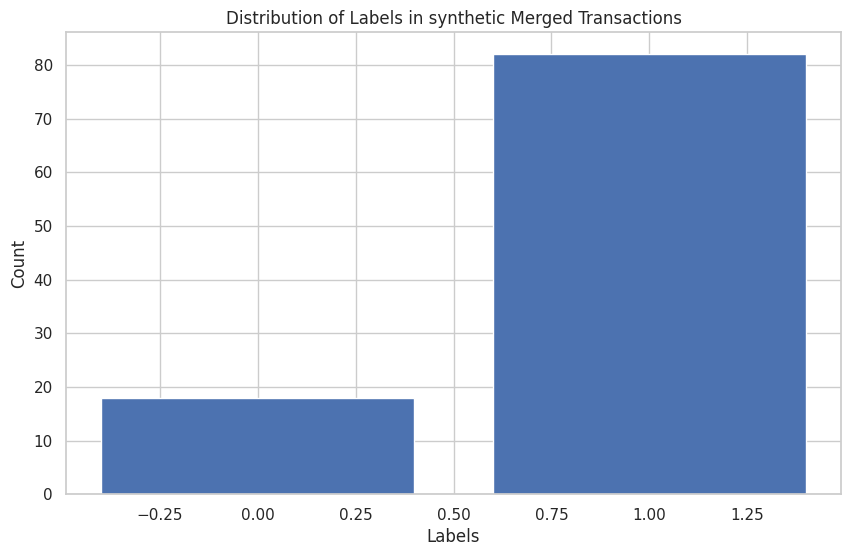

In [ ]:
# Assuming 'merged_transactions' is your DataFrame and 'Label' is your column of interest.
label_counts = merged_transactions['Label'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in synthetic Merged Transactions')
plt.show()


* This distribution is highly imbalanced
* Therefore we have to use a stratified cross validation for our model to generalize better

#### Data preparation and preprocessing

In [ ]:
def prepare_and_preprocess_data(merged_transactions):

  #drop any missing values
  merged_transactions.dropna(inplace = True)

  #label encode the product id:
  le = LabelEncoder()
  merged_transactions['Product_ID_internal'] = le.fit_transform(merged_transactions['Product_ID_internal'] )

  #Select the features and  the target\
  features = ['Product_ID_internal', 'Occurrence_Position', 'Amount_internal']
  target = 'Label'

  return merged_transactions, features, target


merged_transactions, features, target = prepare_and_preprocess_data(merged_transactions)

#### Data Spliting
* we do it in a stratified manner to represent the imbalance in the splits

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(merged_transactions[features], merged_transactions[target],
                                                    test_size = 0.15, stratify = merged_transactions[target],
                                                    random_state = 42)

#### Create our Baseline using our simple if function

In [ ]:
simple_if_model(merged_transactions)

The accuracy score of this simple if model is: 0.18


* well our simple if model scores 0.18 in our generated synthetic dataset, therefore not good enough, lets try to beat it

#### Logistic Regression model
* scale
* fit
* evaluate

In [ ]:

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Fit the Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))






              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.80      1.00      0.89        12

    accuracy                           0.80        15
   macro avg       0.40      0.50      0.44        15
weighted avg       0.64      0.80      0.71        15



### Random Forest Classifier

In [ ]:

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Logistic Regression model
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.80      1.00      0.89        12

    accuracy                           0.80        15
   macro avg       0.40      0.50      0.44        15
weighted avg       0.64      0.80      0.71        15



### Conclusions:
* The accuracy has improved from 0.18 in our simple if function to 0.80 for both logistic regression and random forest
*  The best metric for such cases is F1 score since our data was highly imbalanced
* The best we can get is 0.44 F1 in both logistic regression and RandomForest
* Well this is synthetic data, We can't base our results on this. Another chance to beg for more quality data

### KMEANS CLUSTERING

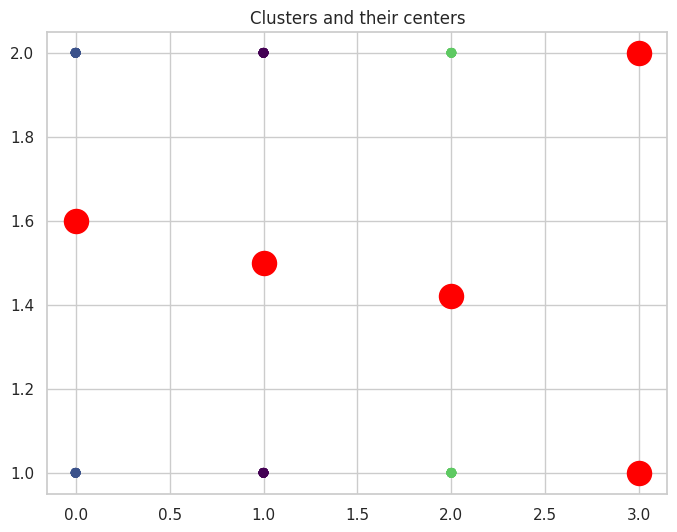

In [ ]:
X = merged_transactions[features]

def perform_kmeans_clustering(X: pd.DataFrame):
  silhouette_scores = []
  K = range(2, 10)

  for k in K:
      kmeans = KMeans(n_clusters=k, random_state=42)
      kmeans.fit(X)
      score = silhouette_score(X, kmeans.labels_)
      silhouette_scores.append(score)

  # The optimal k is the one with the highest silhouette score
  optimal_k = K[silhouette_scores.index(max(silhouette_scores))]

  # Perform KMeans clustering with the optimal k
  kmeans = KMeans(n_clusters=optimal_k, random_state=42)
  kmeans.fit(X)

  # Visualize the clusters
  plt.figure(figsize=(8, 6))

  plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans.labels_, cmap='viridis')

  plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
  plt.title('Clusters and their centers')
  plt.show()

perform_kmeans_clustering(X)


#### Conclusion
* The plot shows three distinct clusters of data points, each represented by a different color (blue, purple, and green). Each cluster groups together data points that are similar to each other based on certain characteristics or features.
* The colored dots at the corners of the plot (blue, purple, and green) represent the centers of their respective clusters. These are calculated as the mean (or sometimes median) of all the data points belonging to a cluster.
* The red dots scattered across the plot represent individual data points. Each data point is assigned to the cluster whose center is closest to it.

### Data Engineering Pipeline
* Well Since there is no real data, I will implement a simple data pipeline in python that mimics the data pipeline

In [ ]:
def data_pipeline(training_data, internal_transactions, gateway_transactions, features, target):
    # Fetch new transaction data from both sources
    # In this case, I assume that the data is already provided as input to the function
    # In a real-world scenario, I might fetch this data from a database or an API


    # train the model with training data
    model = build_logistic_regression_model(training_data, features, target)

    # identify discrepancies
    discrepancies = flag_discrepancies(model, internal_transactions, gateway_transactions, features)

    #reconcile discrepancies
    corrected_internal_transactions, corrected_gateway_transactions = reconcile_data(internal_transactions, gateway_transactions, discrepancies)

    return corrected_internal_transactions, corrected_gateway_transactions

def reconcile_data(internal_transactions, gateway_transactions, discrepancies):
    corrected_internal_transactions = internal_transactions.copy()
    corrected_gateway_transactions = gateway_transactions.copy()

    # Create a dictionary for correct product prices
    correct_prices = {
        'A1001': 299.99,
        'A1002': 159.50,
        'A1003': 49.99,
        'A1004': 89.90
    }

    # Iterate over discrepancies
    for id in discrepancies.Transaction_ID.unique():
        # Get the corresponding internal transaction
        internal_transaction = corrected_internal_transactions.loc[corrected_internal_transactions['Transaction_ID'] == id]

        # Get the corresponding gateway transaction
        gateway_transaction = corrected_gateway_transactions.loc[corrected_gateway_transactions['Transaction_ID'] == id]

        # Get the correct price for the product
        correct_price = correct_prices[internal_transaction['Product_ID_internal'].values[0]]

        # Correct the internal transaction amount
        internal_transaction['Amount_internal'] = correct_price

        # Correct the gateway transaction amount
        gateway_transaction['Amount'] = correct_price

        # Update the transactions in the dataframes
        corrected_internal_transactions.loc[corrected_internal_transactions['Transaction_ID'] == id] = internal_transaction
        corrected_gateway_transactions.loc[corrected_gateway_transactions['Transaction_ID'] == id] = gateway_transaction

    return corrected_internal_transactions, corrected_gateway_transactions

def build_logistic_regression_model(data, features, target):
  X_train, X_test, y_train, y_test = train_test_split(data[features], data[target],
                                                      test_size = 0.15, stratify = data[target],
                                                      random_state = 42)

  # Scale the data
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)


  # Fit the Logistic Regression model
  model = LogisticRegression()
  model.fit(X_train_scaled, y_train)

  # Make predictions
  y_pred = model.predict(X_test_scaled)

  # Evaluate the model
  print(classification_report(y_test, y_pred))\

  return model

def flag_discrepancies(model, internal_transactions, gateway_transactions, features):
    # Use a trained model to predict and flag potential future discrepancies
    merged_transactions = build_modelling_data(internal_transactions, gateway_transactions)
    predictions = model.predict(merged_transactions[features])
    merged_transactions['predictions'] = predictions
    flagged_transactions = merged_transactions[merged_transactions['predictions'] == 1]
    return flagged_transactions

def build_modelling_data(internal_df, gateway_df):
  merged_transactions = pd.merge(internal_df, gateway_df, on='Transaction_ID', suffixes=('_internal', '_gateway'))
  merged_transactions['Occurrence_Position'] = np.where(merged_transactions.index % 2 == 0, 1, 2)
  merged_transactions['Label'] = np.where(merged_transactions['Amount_internal'] != merged_transactions['Amount_gateway'], 1, 0)
  return merged_transactions




In [ ]:
features = ['Product_ID_internal', 'Occurrence_Position', 'Amount_internal']
target = 'Label'
training_data = merged_transactions.copy()
internal_transactions = pd.read_csv(CFG.path + "INTERNAL_TRANSACTIONS_PATH")
gateway_transactions = pd.read_csv(CFG.path + "GATEWAY_TRANSACTIONS_PATH")

corrected_internal_transactions, corrected_gateway_transactions = data_pipeline(training_data, internal_transactions, gateway_transactions, features, target)
